In [1]:
"""
Importing required libraries
"""
import sys
import sklearn
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import mixture
from sklearn.decomposition import FastICA, PCA
from sklearn import random_projection
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import silhouette_score,confusion_matrix,classification_report,plot_confusion_matrix
from sklearn.metrics import silhouette_samples
from sklearn.metrics import mean_squared_error
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.metrics import adjusted_mutual_info_score,mutual_info_score,adjusted_rand_score,homogeneity_completeness_v_measure
from time import time
from scipy.io.arff import loadarff 
import numpy as np
import itertools
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)
import tensorflow as tf
from tensorflow import keras
import os
from matplotlib.colors import LogNorm
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
random_state = np.random.RandomState(17)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Dataset 
Refrences:
- https://www.kaggle.com/ronitf/heart-disease-uci
- https://archive.ics.uci.edu/ml/datasets/Heart+Disease
- https://archive.ics.uci.edu/ml/datasets/Diabetic+Retinopathy+Debrecen+Data+Set

## Dataset Attribute Information:
Dataset name: Messidor (Diabetic Retinopathy Debrecen)
following description of fetures are obtainbed from: https://archive.ics.uci.edu/ml/datasets/Diabetic+Retinopathy+Debrecen+Data+Set

- 0) quality of image (Binart 0:Bad 1: acceptable)
- 1) pre-screening indication of disease 0: no sign 1: disease is present
- 2-7) " The results of MA detection. Each feature value stand for the
        number of MAs found at the confidence levels alpha = 0.5, . . . , 1, respectively".
- 8-15) similar to (2-7) for exudates. see refrence for more information.
- 16) The euclidean distance feture of patients retina
- 17) optic disc diameter.
- 18) AM/FM based class (binary).
- 19) 1 = contains signs disease, 0 = no signs

In [3]:
messidor_data_path = os.path.join("Data", "messidor_features.arff")
messidor_data = loadarff(messidor_data_path)
messidor = pd.DataFrame(messidor_data[0])
messidor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 20 columns):
0        1151 non-null float64
1        1151 non-null float64
2        1151 non-null float64
3        1151 non-null float64
4        1151 non-null float64
5        1151 non-null float64
6        1151 non-null float64
7        1151 non-null float64
8        1151 non-null float64
9        1151 non-null float64
10       1151 non-null float64
11       1151 non-null float64
12       1151 non-null float64
13       1151 non-null float64
14       1151 non-null float64
15       1151 non-null float64
16       1151 non-null float64
17       1151 non-null float64
18       1151 non-null float64
Class    1151 non-null object
dtypes: float64(19), object(1)
memory usage: 180.0+ KB


In [4]:
messidor["Class"].value_counts()

b'1'    611
b'0'    540
Name: Class, dtype: int64

## Load/Split/Process Data:

In [5]:
messidor_train_set, messidor_test_set = train_test_split(messidor, test_size=0.2, random_state=17)
# Separate predictors and labels for messidor data
messidor_train_features = messidor_train_set.drop("Class",axis=1)
messidor_train_labels = messidor_train_set["Class"].copy()
# identifying the categorical and numerical data for messidor data
messidor_cat_attrs = ['0','1','18']
messidor_num_attrs = [c for c in messidor_train_features.columns if c not in messidor_cat_attrs ]
messidor_train_labels.value_counts()

# preprocessing the messidor data
pipeline = ColumnTransformer([
        ("num", StandardScaler(), messidor_num_attrs),
        ("cat", OneHotEncoder(), messidor_cat_attrs),
    ])
    
X = pipeline.fit_transform(messidor_train_features)
ordinal_encoder = LabelEncoder()
y = ordinal_encoder.fit_transform(messidor_train_labels)
# messidor test set preprocessing
messidor_test_features = messidor_test_set.drop("Class",axis=1)
messidor_test_prep = pipeline.transform(messidor_test_features)
messidor_test_labels = messidor_test_set["Class"].copy()
messidor_test_labels_prep = ordinal_encoder.transform(messidor_test_labels)

Class_label=['No signs of DR','Contains signs of DR']

In [6]:
def plot_clusters(X, y=None,s=4):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=s)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

def plot_data(X,y_true=None):
    plt.scatter(X[:, 0], X[:, 1], c=y_true,s=3)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X,y_true=None, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X,y_true)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
        plt.tick_params(labelleft=False)


def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')


Saving figure messidor_plot


<Figure size 800x400 with 0 Axes>

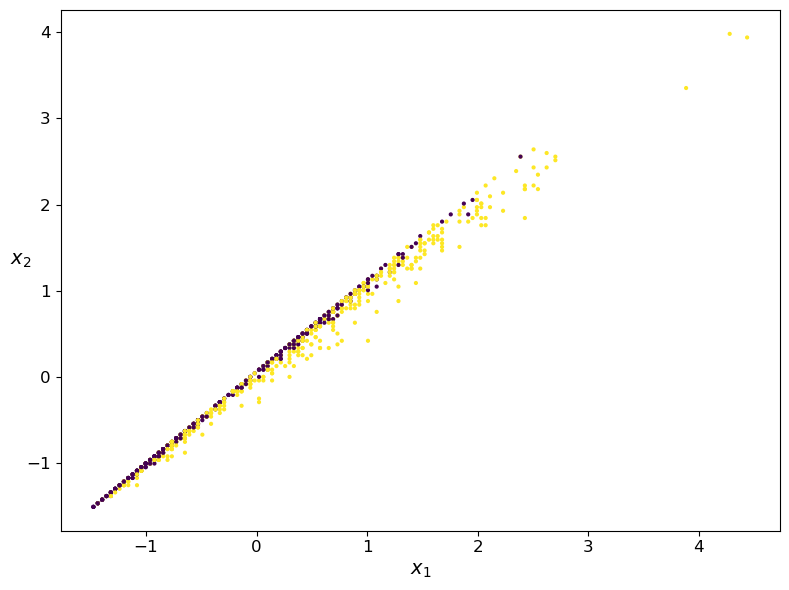

In [7]:
plt.figure(figsize=(8, 4))
plot_clusters(X,y)
save_fig("messidor_plot")
plt.show()

# PART 2: Apply dimensionality reduction to dataset and run Neural Network model:
Note: Optimum dimensions from part 1 were used in this section

In [7]:

def nn_parameter_study(X,y,n=300,l=1,lr=0.01,epochs=200,range_n=None,num_layer=None,range_lr=None):
    
    early_stopping = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

    v_range =[]
    train_score=[]
    val_score=[]
    if range_n is not None:
        v_range = range_n
        x_label='Number of Neurons'
    elif range_lr is not None:
        v_range = range_lr
        x_label='Learning Rate'
    else:
        v_range = np.arange(1,num_layer+1)
        x_label='Number of Layers'
    for v in v_range:
        tf.keras.backend.clear_session()
        model = keras.models.Sequential()
        model.add(keras.layers.InputLayer(input_shape=X.shape[1]))
        for i in range(l if num_layer is None else v): 
            model.add(keras.layers.Dense(n if range_n is None else v, activation="relu"))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(loss="binary_crossentropy", optimizer =keras.optimizers.SGD(lr=lr if range_lr is None else v),metrics = ["accuracy"])
        model_history = model.fit(X,y,epochs=epochs,validation_split=0.2,callbacks=[early_stopping])
        
        
        train_score.append(model_history.history['accuracy'][-1])
        val_score.append(model_history.history['val_accuracy'][-1])
    plt.plot(v_range,train_score, "g-", linewidth=2, label="train_score")
    plt.plot(v_range,val_score, "y-", linewidth=3, label="val_score")
    plt.legend(loc="lower right", fontsize=14)  
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel("Score", fontsize=14)
    plt.title("Hyperparameter Study -NN", fontsize=14)
    # plt.gca().set_ylim(0, 1)
    plt.show()

## 2.1- PCA

In [8]:
pca = PCA(n_components=7,random_state=9)
X_DR_pca = pca.fit_transform(X)

2/200
736/736 [==============================] - 0s 92us/sample - loss: 0.6691 - accuracy: 0.5734 - val_loss: 0.6660 - val_accuracy: 0.5326
Epoch 3/200
736/736 [==============================] - 0s 113us/sample - loss: 0.6575 - accuracy: 0.5747 - val_loss: 0.6594 - val_accuracy: 0.5489
Epoch 4/200
736/736 [==============================] - 0s 126us/sample - loss: 0.6505 - accuracy: 0.5761 - val_loss: 0.6553 - val_accuracy: 0.5598
Epoch 5/200
736/736 [==============================] - 0s 128us/sample - loss: 0.6459 - accuracy: 0.6005 - val_loss: 0.6520 - val_accuracy: 0.5598
Epoch 6/200
736/736 [==============================] - 0s 120us/sample - loss: 0.6426 - accuracy: 0.6128 - val_loss: 0.6496 - val_accuracy: 0.5707
Epoch 7/200
736/736 [==============================] - 0s 128us/sample - loss: 0.6401 - accuracy: 0.6141 - val_loss: 0.6475 - val_accuracy: 0.5815
Epoch 8/200
736/736 [==============================] - 0s 114us/sample - loss: 0.6378 - accuracy: 0.6141 - val_loss: 0.6459 -

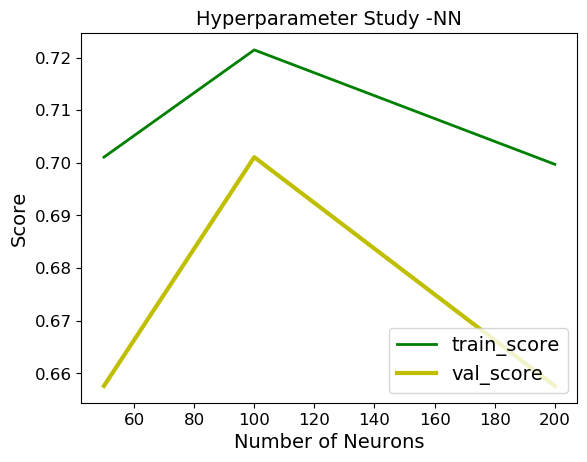

In [19]:
# number of neurons vs score
range_n=[50,100,200]
nn_parameter_study(X_DR_pca,y,n=100,l=2,lr=0.01,epochs=200,range_n=range_n,range_lr=None)

 val_loss: 0.5758 - val_accuracy: 0.6630
Epoch 202/300
736/736 [==============================] - 0s 90us/sample - loss: 0.5365 - accuracy: 0.7188 - val_loss: 0.5746 - val_accuracy: 0.6576
Epoch 203/300
736/736 [==============================] - 0s 87us/sample - loss: 0.5356 - accuracy: 0.7201 - val_loss: 0.5759 - val_accuracy: 0.6522
Epoch 204/300
736/736 [==============================] - 0s 129us/sample - loss: 0.5355 - accuracy: 0.7242 - val_loss: 0.5754 - val_accuracy: 0.6522
Epoch 205/300
736/736 [==============================] - 0s 71us/sample - loss: 0.5358 - accuracy: 0.7188 - val_loss: 0.5738 - val_accuracy: 0.6576
Epoch 206/300
736/736 [==============================] - 0s 86us/sample - loss: 0.5352 - accuracy: 0.7201 - val_loss: 0.5735 - val_accuracy: 0.6576
Epoch 207/300
736/736 [==============================] - 0s 95us/sample - loss: 0.5351 - accuracy: 0.7255 - val_loss: 0.5746 - val_accuracy: 0.6576
Epoch 208/300
736/736 [==============================] - 0s 98us/sampl

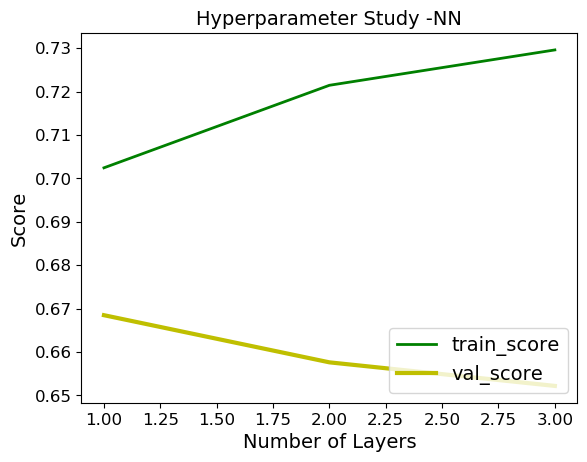

In [20]:
nn_parameter_study(X_DR_pca,y,n=100,lr=0.01,l=2,epochs=300,range_n=None,num_layer=3,range_lr=None)

========] - 0s 125us/sample - loss: 0.5949 - accuracy: 0.6630 - val_loss: 0.6096 - val_accuracy: 0.6413
Epoch 67/200
736/736 [==============================] - 0s 130us/sample - loss: 0.5945 - accuracy: 0.6630 - val_loss: 0.6089 - val_accuracy: 0.6522
Epoch 68/200
736/736 [==============================] - 0s 124us/sample - loss: 0.5938 - accuracy: 0.6671 - val_loss: 0.6086 - val_accuracy: 0.6522
Epoch 69/200
736/736 [==============================] - 0s 97us/sample - loss: 0.5935 - accuracy: 0.6685 - val_loss: 0.6082 - val_accuracy: 0.6522
Epoch 70/200
736/736 [==============================] - 0s 109us/sample - loss: 0.5929 - accuracy: 0.6658 - val_loss: 0.6077 - val_accuracy: 0.6522
Epoch 71/200
736/736 [==============================] - 0s 99us/sample - loss: 0.5926 - accuracy: 0.6671 - val_loss: 0.6073 - val_accuracy: 0.6522
Epoch 72/200
736/736 [==============================] - 0s 118us/sample - loss: 0.5921 - accuracy: 0.6698 - val_loss: 0.6069 - val_accuracy: 0.6576
Epoch 73/2

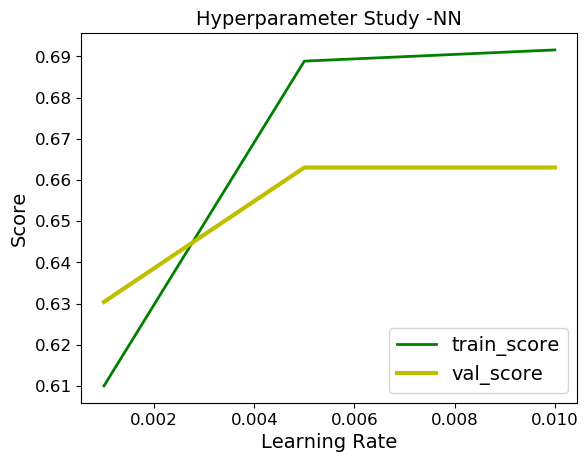

In [21]:
range_lr =[0.001,0.005,0.01]
nn_parameter_study(X_DR_pca,y,n=150,lr=0.01,l=1,epochs=200,range_n=None,range_lr=range_lr)

In [9]:
# Creating MLP NN
tf.keras.backend.clear_session()

model_NN_PCA = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=X_DR_pca.shape[1]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")])

In [10]:
model_NN_PCA.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               800       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 901
Trainable params: 901
Non-trainable params: 0
_________________________________________________________________


In [11]:
model_NN_PCA.compile(loss="binary_crossentropy",
              optimizer =keras.optimizers.SGD(lr=0.005),
              metrics = ["accuracy"])

In [12]:
early_stopping = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
model_history_PCA = model_NN_PCA.fit(X_DR_pca,y,epochs=300,validation_split=0.2,callbacks=[early_stopping])

 0.6359
Epoch 166/300
736/736 [==============================] - 0s 89us/sample - loss: 0.5828 - accuracy: 0.6780 - val_loss: 0.5989 - val_accuracy: 0.6359
Epoch 167/300
736/736 [==============================] - 0s 68us/sample - loss: 0.5826 - accuracy: 0.6793 - val_loss: 0.5987 - val_accuracy: 0.6359
Epoch 168/300
736/736 [==============================] - 0s 73us/sample - loss: 0.5823 - accuracy: 0.6793 - val_loss: 0.5986 - val_accuracy: 0.6359
Epoch 169/300
736/736 [==============================] - 0s 77us/sample - loss: 0.5821 - accuracy: 0.6821 - val_loss: 0.5984 - val_accuracy: 0.6359
Epoch 170/300
736/736 [==============================] - 0s 76us/sample - loss: 0.5819 - accuracy: 0.6875 - val_loss: 0.5983 - val_accuracy: 0.6359
Epoch 171/300
736/736 [==============================] - 0s 75us/sample - loss: 0.5817 - accuracy: 0.6821 - val_loss: 0.5982 - val_accuracy: 0.6359
Epoch 172/300
736/736 [==============================] - 0s 82us/sample - loss: 0.5815 - accuracy: 0.684

In [13]:
model_history_PCA.history['val_accuracy'][-1]

0.6467391

In [14]:
model_history_PCA.history['accuracy'][-1]

0.6942935

Saving figure PCA_keras_learning_curves_plot


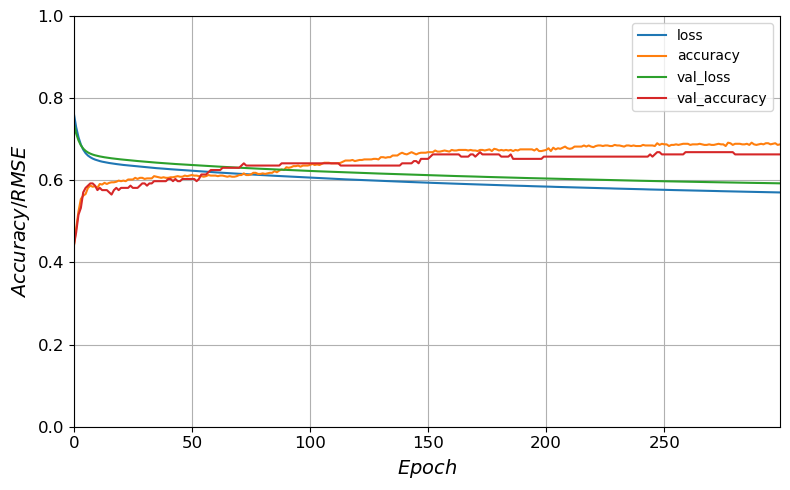

In [47]:
pd.DataFrame(model_history_PCA.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel("$Epoch$", fontsize=14)
plt.ylabel("$Accuracy/RMSE$", fontsize=14)

save_fig("PCA_keras_learning_curves_plot")
plt.show()

231/231 [==============================] - 0s 82us/sample - loss: 0.7952 - accuracy: 0.5628
[0.795220515944741, 0.56277055]
                      precision    recall  f1-score   support

      No signs of DR       0.56      0.53      0.55       115
Contains signs of DR       0.56      0.59      0.58       116

            accuracy                           0.56       231
           macro avg       0.56      0.56      0.56       231
        weighted avg       0.56      0.56      0.56       231



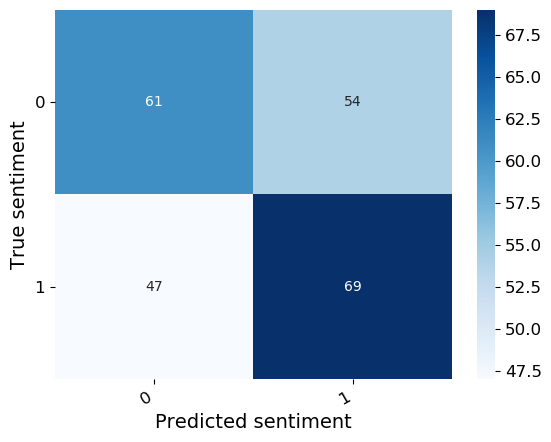

In [57]:
X_test_pca = X_DR_pca = pca.fit_transform(messidor_test_prep)
acc = model_NN_PCA.evaluate(X_test_pca,messidor_test_labels_prep)
print(acc)
y_pred_PCA = model_NN_PCA.predict_classes(X_test_pca)

cm = confusion_matrix(messidor_test_labels_prep, y_pred_PCA)
df_cm = pd.DataFrame(cm)#, index=Class_label[:], columns=Class_label[:])
show_confusion_matrix(df_cm)
print(classification_report(messidor_test_labels_prep, y_pred_PCA, target_names=Class_label[:]))

## 2.2- ICA

In [58]:
ica = FastICA(n_components=17,random_state=9)
X_DR_ICA = ica.fit_transform(X)

200
736/736 [==============================] - 0s 91us/sample - loss: 0.6817 - accuracy: 0.5462 - val_loss: 0.6883 - val_accuracy: 0.5054
Epoch 67/200
736/736 [==============================] - 0s 96us/sample - loss: 0.6817 - accuracy: 0.5462 - val_loss: 0.6883 - val_accuracy: 0.5054
Epoch 68/200
736/736 [==============================] - 0s 90us/sample - loss: 0.6816 - accuracy: 0.5462 - val_loss: 0.6882 - val_accuracy: 0.5054
Epoch 69/200
736/736 [==============================] - 0s 100us/sample - loss: 0.6815 - accuracy: 0.5462 - val_loss: 0.6882 - val_accuracy: 0.5054
Epoch 70/200
736/736 [==============================] - 0s 86us/sample - loss: 0.6815 - accuracy: 0.5462 - val_loss: 0.6881 - val_accuracy: 0.5054
Epoch 71/200
736/736 [==============================] - 0s 102us/sample - loss: 0.6814 - accuracy: 0.5462 - val_loss: 0.6880 - val_accuracy: 0.5054
Epoch 72/200
736/736 [==============================] - 0s 94us/sample - loss: 0.6814 - accuracy: 0.5462 - val_loss: 0.6879 -

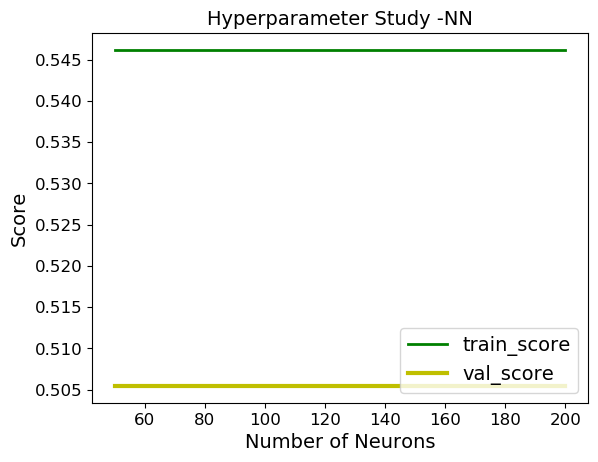

In [49]:
# number of neurons vs score
range_n=[50,100,200]
nn_parameter_study(X_DR_ICA,y,n=100,l=2,lr=0.01,epochs=200,range_n=range_n,range_lr=None)

=============================] - 0s 102us/sample - loss: 0.6644 - accuracy: 0.5462 - val_loss: 0.6723 - val_accuracy: 0.5054
Epoch 167/300
736/736 [==============================] - 0s 107us/sample - loss: 0.6641 - accuracy: 0.5462 - val_loss: 0.6717 - val_accuracy: 0.5054
Epoch 168/300
736/736 [==============================] - 0s 90us/sample - loss: 0.6640 - accuracy: 0.5462 - val_loss: 0.6718 - val_accuracy: 0.5054
Epoch 169/300
736/736 [==============================] - 0s 118us/sample - loss: 0.6637 - accuracy: 0.5462 - val_loss: 0.6710 - val_accuracy: 0.5054
Epoch 170/300
736/736 [==============================] - 0s 87us/sample - loss: 0.6633 - accuracy: 0.5462 - val_loss: 0.6706 - val_accuracy: 0.5054
Epoch 171/300
736/736 [==============================] - 0s 87us/sample - loss: 0.6630 - accuracy: 0.5462 - val_loss: 0.6702 - val_accuracy: 0.5054
Epoch 172/300
736/736 [==============================] - 0s 82us/sample - loss: 0.6631 - accuracy: 0.5462 - val_loss: 0.6700 - val_ac

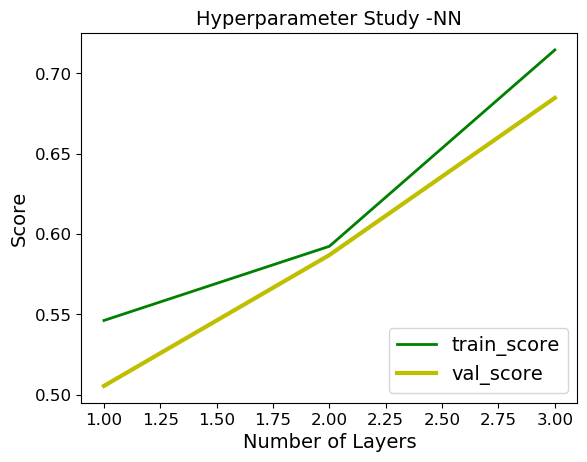

In [51]:
nn_parameter_study(X_DR_ICA,y,n=100,lr=0.01,l=2,epochs=300,range_n=None,num_layer=3,range_lr=None)

 0.5054
Epoch 66/200
736/736 [==============================] - 0s 80us/sample - loss: 0.6770 - accuracy: 0.5462 - val_loss: 0.6826 - val_accuracy: 0.5054
Epoch 67/200
736/736 [==============================] - 0s 72us/sample - loss: 0.6769 - accuracy: 0.5462 - val_loss: 0.6826 - val_accuracy: 0.5054
Epoch 68/200
736/736 [==============================] - 0s 90us/sample - loss: 0.6765 - accuracy: 0.5462 - val_loss: 0.6821 - val_accuracy: 0.5054
Epoch 69/200
736/736 [==============================] - 0s 91us/sample - loss: 0.6764 - accuracy: 0.5462 - val_loss: 0.6818 - val_accuracy: 0.5054
Epoch 70/200
736/736 [==============================] - 0s 90us/sample - loss: 0.6764 - accuracy: 0.5462 - val_loss: 0.6817 - val_accuracy: 0.5054
Epoch 71/200
736/736 [==============================] - 0s 130us/sample - loss: 0.6762 - accuracy: 0.5462 - val_loss: 0.6815 - val_accuracy: 0.5054
Epoch 72/200
736/736 [==============================] - 0s 119us/sample - loss: 0.6760 - accuracy: 0.5462 - v

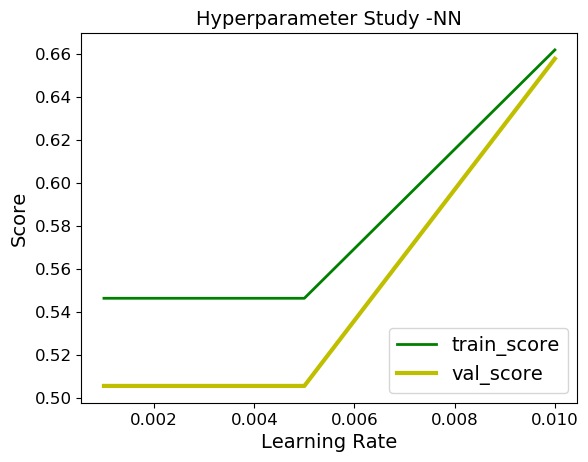

In [52]:
range_lr =[0.001,0.005,0.01]
nn_parameter_study(X_DR_ICA,y,n=100,lr=0.01,l=3,epochs=200,range_n=None,range_lr=range_lr)

In [61]:
# Creating MLP NN
tf.keras.backend.clear_session()

model_NN_ICA = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=X_DR_ICA.shape[1]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),

    keras.layers.Dense(1, activation="sigmoid")])

In [54]:
model_NN_ICA.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1800      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 22,101
Trainable params: 22,101
Non-trainable params: 0
_________________________________________________________________


In [62]:
model_NN_ICA.compile(loss="binary_crossentropy",
              optimizer =keras.optimizers.SGD(lr=0.01),
              metrics = ["accuracy"])

In [63]:
# early_stopping = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
model_history_ICA = model_NN_ICA.fit(X_DR_ICA,y,epochs=300,validation_split=0.2)#,callbacks=[early_stopping])

==============================] - 0s 96us/sample - loss: 0.6597 - accuracy: 0.5856 - val_loss: 0.6656 - val_accuracy: 0.5109
Epoch 167/300
736/736 [==============================] - 0s 154us/sample - loss: 0.6593 - accuracy: 0.5571 - val_loss: 0.6650 - val_accuracy: 0.5109
Epoch 168/300
736/736 [==============================] - 0s 88us/sample - loss: 0.6593 - accuracy: 0.5639 - val_loss: 0.6650 - val_accuracy: 0.5109
Epoch 169/300
736/736 [==============================] - 0s 103us/sample - loss: 0.6586 - accuracy: 0.5571 - val_loss: 0.6641 - val_accuracy: 0.5109
Epoch 170/300
736/736 [==============================] - 0s 86us/sample - loss: 0.6589 - accuracy: 0.5639 - val_loss: 0.6634 - val_accuracy: 0.5163
Epoch 171/300
736/736 [==============================] - 0s 96us/sample - loss: 0.6580 - accuracy: 0.5571 - val_loss: 0.6628 - val_accuracy: 0.5217
Epoch 172/300
736/736 [==============================] - 0s 107us/sample - loss: 0.6577 - accuracy: 0.5571 - val_loss: 0.6616 - val_a

In [64]:
model_history_ICA.history['val_accuracy'][-1]

0.7336956

In [65]:
model_history_ICA.history['accuracy'][-1]

0.7241848

Saving figure ICA_keras_learning_curves_plot


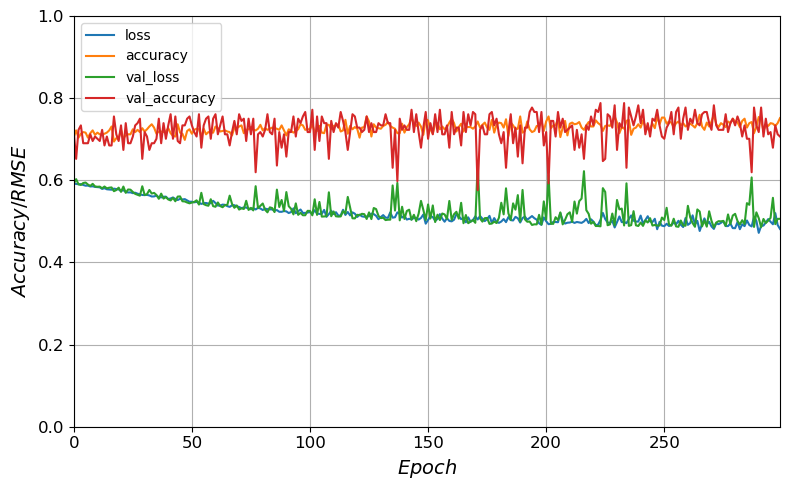

In [63]:
pd.DataFrame(model_history_ICA.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel("$Epoch$", fontsize=14)
plt.ylabel("$Accuracy/RMSE$", fontsize=14)

save_fig("ICA_keras_learning_curves_plot")
plt.show()

231/231 [==============================] - 0s 74us/sample - loss: 0.7767 - accuracy: 0.5065
[0.7766826790132564, 0.5064935]
                      precision    recall  f1-score   support

      No signs of DR       0.50      0.49      0.50       115
Contains signs of DR       0.51      0.53      0.52       116

            accuracy                           0.51       231
           macro avg       0.51      0.51      0.51       231
        weighted avg       0.51      0.51      0.51       231



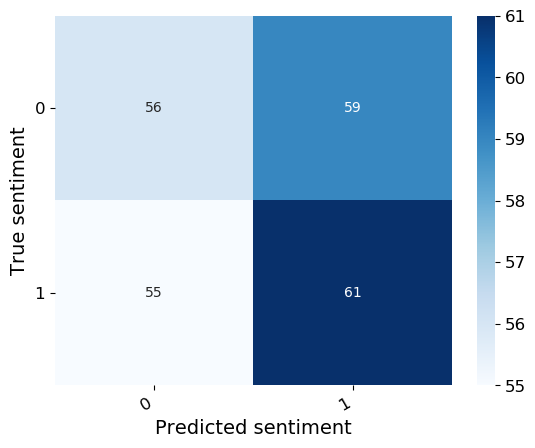

In [66]:
X_test_ICA = ica.fit_transform(messidor_test_prep)
acc = model_NN_ICA.evaluate(X_test_ICA,messidor_test_labels_prep)
print(acc)
y_pred_ICA = model_NN_ICA.predict_classes(X_test_ICA)

cm = confusion_matrix(messidor_test_labels_prep, y_pred_ICA)
df_cm = pd.DataFrame(cm)#, index=Class_label[:], columns=Class_label[:])
show_confusion_matrix(df_cm)
print(classification_report(messidor_test_labels_prep, y_pred_ICA, target_names=Class_label[:]))

## 2.3- RP

In [8]:
for _ in range(50):
    transformer = random_projection.SparseRandomProjection(17,random_state = 9).fit(X)
X_DR_RP = transformer.transform(X)


Epoch 66/200
736/736 [==============================] - 0s 94us/sample - loss: 0.5413 - accuracy: 0.7174 - val_loss: 0.5760 - val_accuracy: 0.6739
Epoch 67/200
736/736 [==============================] - 0s 92us/sample - loss: 0.5402 - accuracy: 0.7201 - val_loss: 0.5750 - val_accuracy: 0.6739
Epoch 68/200
736/736 [==============================] - 0s 109us/sample - loss: 0.5389 - accuracy: 0.7283 - val_loss: 0.5747 - val_accuracy: 0.6685
Epoch 69/200
736/736 [==============================] - 0s 117us/sample - loss: 0.5377 - accuracy: 0.7242 - val_loss: 0.5746 - val_accuracy: 0.6739
Epoch 70/200
736/736 [==============================] - 0s 103us/sample - loss: 0.5361 - accuracy: 0.7269 - val_loss: 0.5733 - val_accuracy: 0.6739
Epoch 71/200
736/736 [==============================] - 0s 113us/sample - loss: 0.5353 - accuracy: 0.7255 - val_loss: 0.5725 - val_accuracy: 0.6848
Epoch 72/200
736/736 [==============================] - 0s 102us/sample - loss: 0.5338 - accuracy: 0.7283 - val_l

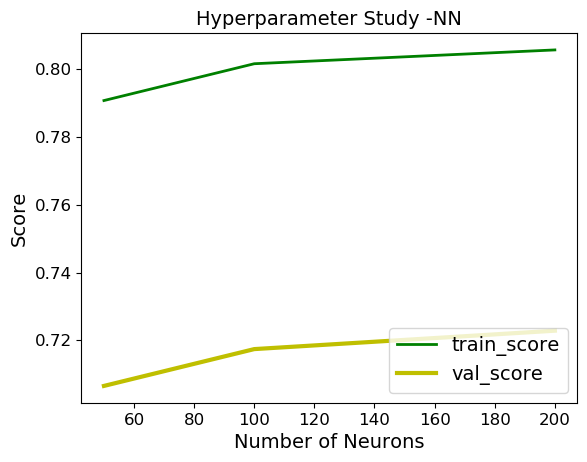

In [65]:
# number of neurons vs score
range_n=[50,100,200]
nn_parameter_study(X_DR_RP,y,n=100,l=2,lr=0.01,epochs=200,range_n=range_n,range_lr=None)

val_accuracy: 0.6957
Epoch 71/300
736/736 [==============================] - 0s 92us/sample - loss: 0.5444 - accuracy: 0.7201 - val_loss: 0.5798 - val_accuracy: 0.6957
Epoch 72/300
736/736 [==============================] - 0s 86us/sample - loss: 0.5425 - accuracy: 0.7269 - val_loss: 0.5789 - val_accuracy: 0.6902
Epoch 73/300
736/736 [==============================] - 0s 91us/sample - loss: 0.5413 - accuracy: 0.7228 - val_loss: 0.5780 - val_accuracy: 0.6957
Epoch 74/300
736/736 [==============================] - 0s 94us/sample - loss: 0.5397 - accuracy: 0.7310 - val_loss: 0.5781 - val_accuracy: 0.6957
Epoch 75/300
736/736 [==============================] - 0s 99us/sample - loss: 0.5389 - accuracy: 0.7242 - val_loss: 0.5765 - val_accuracy: 0.6957
Epoch 76/300
736/736 [==============================] - 0s 95us/sample - loss: 0.5369 - accuracy: 0.7296 - val_loss: 0.5739 - val_accuracy: 0.6793
Epoch 77/300
736/736 [==============================] - 0s 72us/sample - loss: 0.5360 - accuracy:

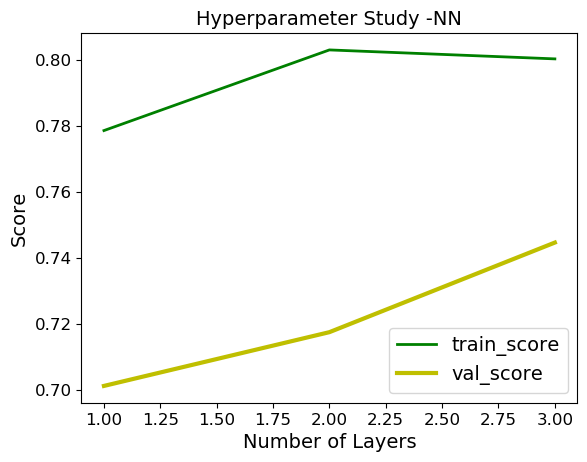

In [66]:
nn_parameter_study(X_DR_RP,y,n=100,lr=0.01,l=2,epochs=300,range_n=None,num_layer=3,range_lr=None)

le - loss: 0.5447 - accuracy: 0.7337 - val_loss: 0.5768 - val_accuracy: 0.6957
Epoch 67/200
736/736 [==============================] - 0s 131us/sample - loss: 0.5441 - accuracy: 0.7283 - val_loss: 0.5761 - val_accuracy: 0.6957
Epoch 68/200
736/736 [==============================] - 0s 122us/sample - loss: 0.5429 - accuracy: 0.7269 - val_loss: 0.5749 - val_accuracy: 0.6957
Epoch 69/200
736/736 [==============================] - 0s 158us/sample - loss: 0.5418 - accuracy: 0.7296 - val_loss: 0.5733 - val_accuracy: 0.6902
Epoch 70/200
736/736 [==============================] - 0s 111us/sample - loss: 0.5402 - accuracy: 0.7337 - val_loss: 0.5742 - val_accuracy: 0.6957
Epoch 71/200
736/736 [==============================] - 0s 142us/sample - loss: 0.5395 - accuracy: 0.7323 - val_loss: 0.5720 - val_accuracy: 0.6902
Epoch 72/200
736/736 [==============================] - 0s 139us/sample - loss: 0.5385 - accuracy: 0.7378 - val_loss: 0.5718 - val_accuracy: 0.6902
Epoch 73/200
736/736 [===========

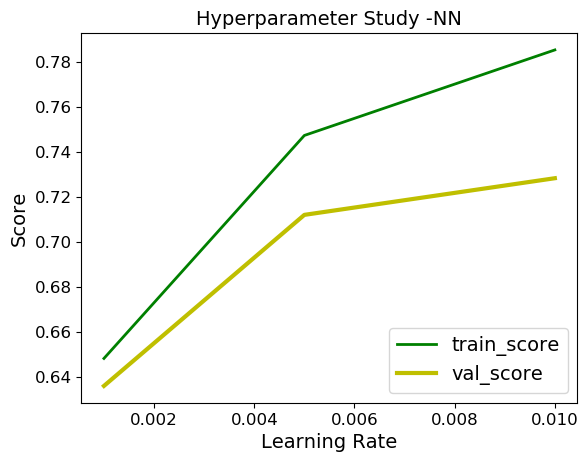

In [69]:
range_lr =[0.001,0.005,0.01]
nn_parameter_study(X_DR_RP,y,n=100,lr=0.01,l=2,epochs=200,range_n=None,range_lr=range_lr)

In [9]:
# Creating MLP NN
tf.keras.backend.clear_session()

model_NN_RP = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=X_DR_RP.shape[1]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),

    keras.layers.Dense(1, activation="sigmoid")])

In [10]:
model_NN_RP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1800      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 12,001
Trainable params: 12,001
Non-trainable params: 0
_________________________________________________________________


In [11]:
model_NN_RP.compile(loss="binary_crossentropy",
              optimizer =keras.optimizers.SGD(lr=0.01),
              metrics = ["accuracy"])

In [12]:
early_stopping = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
model_history_RP = model_NN_RP.fit(X_DR_RP,y,epochs=300,validation_split=0.2,callbacks=[early_stopping])

: 0.7120
Epoch 119/300
736/736 [==============================] - 0s 82us/sample - loss: 0.5015 - accuracy: 0.7568 - val_loss: 0.5499 - val_accuracy: 0.7120
Epoch 120/300
736/736 [==============================] - 0s 79us/sample - loss: 0.5013 - accuracy: 0.7514 - val_loss: 0.5490 - val_accuracy: 0.7228
Epoch 121/300
736/736 [==============================] - 0s 90us/sample - loss: 0.5014 - accuracy: 0.7432 - val_loss: 0.5495 - val_accuracy: 0.7065
Epoch 122/300
736/736 [==============================] - 0s 86us/sample - loss: 0.5007 - accuracy: 0.7514 - val_loss: 0.5496 - val_accuracy: 0.7065
Epoch 123/300
736/736 [==============================] - 0s 102us/sample - loss: 0.4993 - accuracy: 0.7541 - val_loss: 0.5505 - val_accuracy: 0.7011
Epoch 124/300
736/736 [==============================] - 0s 92us/sample - loss: 0.4987 - accuracy: 0.7568 - val_loss: 0.5493 - val_accuracy: 0.7065
Epoch 125/300
736/736 [==============================] - 0s 92us/sample - loss: 0.4978 - accuracy: 0.7

In [13]:
model_history_RP.history['val_accuracy'][-1]

0.7119565

In [14]:
model_history_RP.history['accuracy'][-1]

0.7975544

Saving figure RP_keras_learning_curves_plot


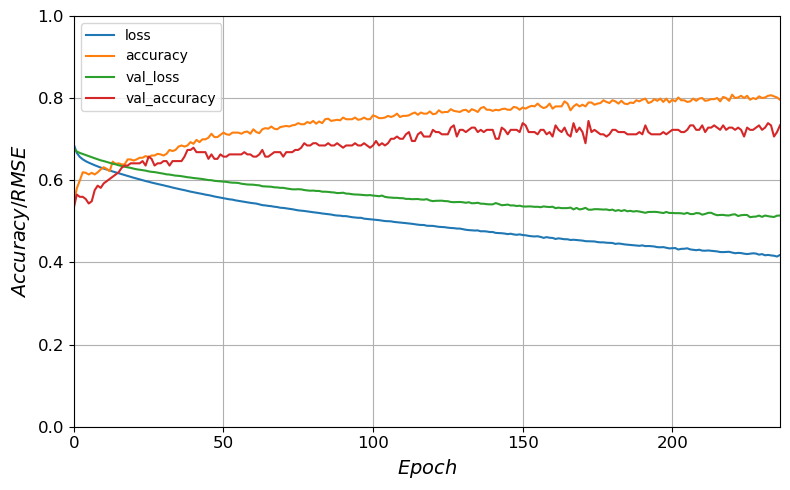

In [74]:
pd.DataFrame(model_history_RP.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel("$Epoch$", fontsize=14)
plt.ylabel("$Accuracy/RMSE$", fontsize=14)

save_fig("RP_keras_learning_curves_plot")
plt.show()

231/231 [==============================] - 0s 104us/sample - loss: 0.5609 - accuracy: 0.7229
[0.5609266378662803, 0.7229437]
                      precision    recall  f1-score   support

      No signs of DR       0.73      0.70      0.71       115
Contains signs of DR       0.71      0.75      0.73       116

            accuracy                           0.72       231
           macro avg       0.72      0.72      0.72       231
        weighted avg       0.72      0.72      0.72       231



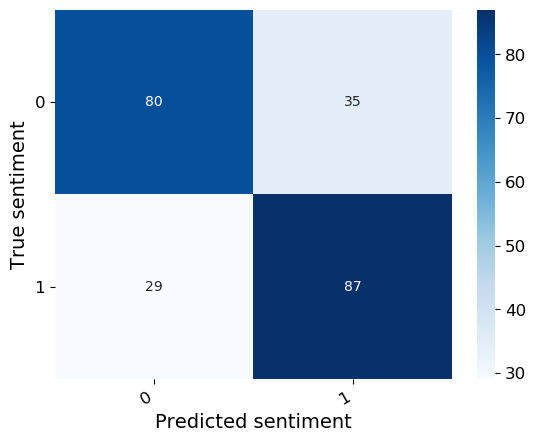

In [15]:
X_test_RP = transformer.fit_transform(messidor_test_prep)
acc = model_NN_RP.evaluate(X_test_RP,messidor_test_labels_prep)
print(acc)
y_pred_RP = model_NN_RP.predict_classes(X_test_RP)

cm = confusion_matrix(messidor_test_labels_prep, y_pred_RP)
df_cm = pd.DataFrame(cm)#, index=Class_label[:], columns=Class_label[:])
show_confusion_matrix(df_cm)
print(classification_report(messidor_test_labels_prep, y_pred_RP, target_names=Class_label[:]))

## 2.4- LLE

In [74]:
lle = LocallyLinearEmbedding(n_components=8, n_neighbors=22,method='modified', random_state=0)
X_DR_LLE = lle.fit_transform(X)

Train on 736 samples, validate on 184 samples
Epoch 1/200
736/736 [==============================] - 1s 693us/sample - loss: 0.6921 - accuracy: 0.5652 - val_loss: 0.6921 - val_accuracy: 0.5054
Epoch 2/200
736/736 [==============================] - 0s 100us/sample - loss: 0.6912 - accuracy: 0.5408 - val_loss: 0.6918 - val_accuracy: 0.4674
Epoch 3/200
736/736 [==============================] - 0s 72us/sample - loss: 0.6904 - accuracy: 0.5340 - val_loss: 0.6916 - val_accuracy: 0.4674
Epoch 4/200
736/736 [==============================] - 0s 94us/sample - loss: 0.6898 - accuracy: 0.5408 - val_loss: 0.6915 - val_accuracy: 0.4837
Epoch 5/200
736/736 [==============================] - 0s 89us/sample - loss: 0.6893 - accuracy: 0.5367 - val_loss: 0.6914 - val_accuracy: 0.4891
Epoch 6/200
736/736 [==============================] - 0s 100us/sample - loss: 0.6888 - accuracy: 0.5408 - val_loss: 0.6914 - val_accuracy: 0.4946
Epoch 7/200
736/736 [==============================] - 0s 87us/sample - los

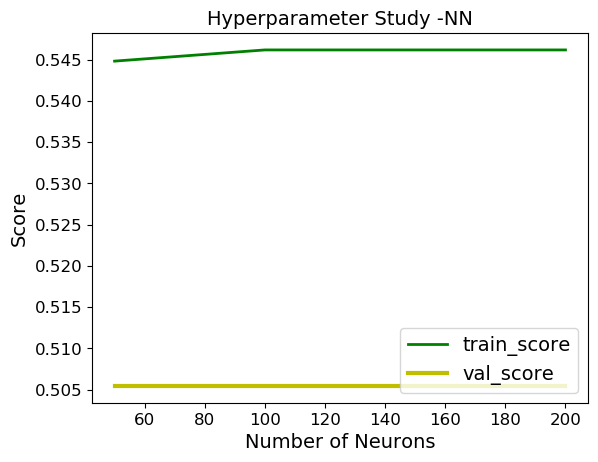

In [78]:
# number of neurons vs score
range_n=[50,100,200]
nn_parameter_study(X_DR_LLE,y,n=100,l=1,lr=0.01,epochs=200,range_n=range_n,range_lr=None)

Train on 736 samples, validate on 184 samples
Epoch 1/300
736/736 [==============================] - 0s 628us/sample - loss: 0.6925 - accuracy: 0.5204 - val_loss: 0.6930 - val_accuracy: 0.4783
Epoch 2/300
736/736 [==============================] - 0s 135us/sample - loss: 0.6918 - accuracy: 0.5462 - val_loss: 0.6929 - val_accuracy: 0.5054
Epoch 3/300
736/736 [==============================] - 0s 124us/sample - loss: 0.6912 - accuracy: 0.5462 - val_loss: 0.6928 - val_accuracy: 0.5054
Epoch 4/300
736/736 [==============================] - 0s 94us/sample - loss: 0.6907 - accuracy: 0.5462 - val_loss: 0.6927 - val_accuracy: 0.5054
Epoch 5/300
736/736 [==============================] - 0s 88us/sample - loss: 0.6903 - accuracy: 0.5462 - val_loss: 0.6927 - val_accuracy: 0.5054
Epoch 6/300
736/736 [==============================] - 0s 95us/sample - loss: 0.6899 - accuracy: 0.5462 - val_loss: 0.6927 - val_accuracy: 0.5054
Epoch 7/300
736/736 [==============================] - 0s 92us/sample - los

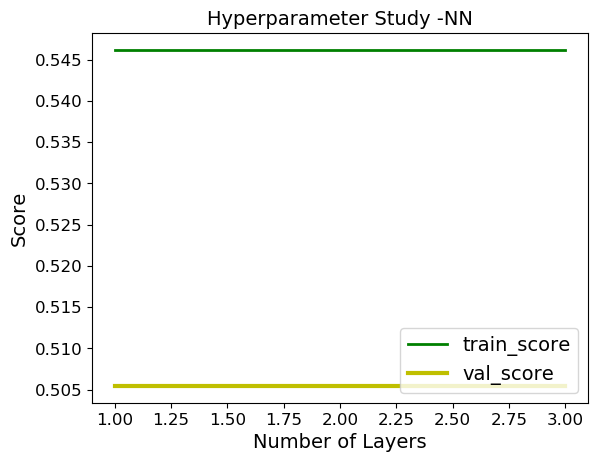

In [79]:
nn_parameter_study(X_DR_LLE,y,n=100,lr=0.005,l=1,epochs=300,range_n=None,num_layer=3,range_lr=None)

Train on 736 samples, validate on 184 samples
Epoch 1/200
736/736 [==============================] - 1s 899us/sample - loss: 0.6936 - accuracy: 0.4674 - val_loss: 0.6932 - val_accuracy: 0.5054
Epoch 2/200
736/736 [==============================] - 0s 114us/sample - loss: 0.6935 - accuracy: 0.4715 - val_loss: 0.6931 - val_accuracy: 0.5489
Epoch 3/200
736/736 [==============================] - 0s 103us/sample - loss: 0.6934 - accuracy: 0.4810 - val_loss: 0.6931 - val_accuracy: 0.5489
Epoch 4/200
736/736 [==============================] - 0s 96us/sample - loss: 0.6933 - accuracy: 0.4918 - val_loss: 0.6931 - val_accuracy: 0.5272
Epoch 5/200
736/736 [==============================] - 0s 95us/sample - loss: 0.6932 - accuracy: 0.4918 - val_loss: 0.6930 - val_accuracy: 0.5217
Epoch 6/200
736/736 [==============================] - 0s 92us/sample - loss: 0.6931 - accuracy: 0.5095 - val_loss: 0.6930 - val_accuracy: 0.5435
Epoch 7/200
736/736 [==============================] - 0s 94us/sample - los

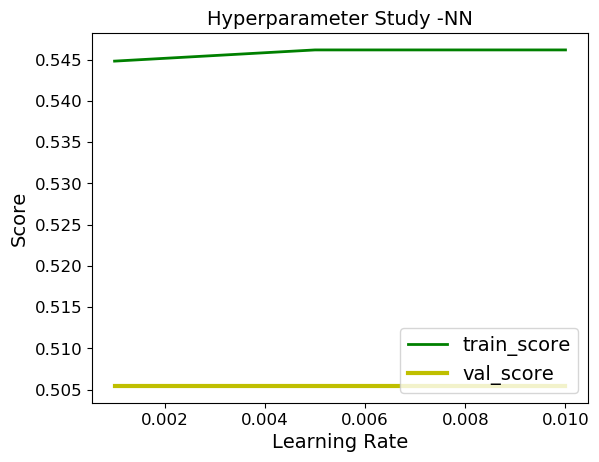

In [80]:
range_lr =[0.001,0.005,0.01]
nn_parameter_study(X_DR_LLE,y,n=100,lr=0.01,l=1,epochs=200,range_n=None,range_lr=range_lr)

In [75]:
# Creating MLP NN
tf.keras.backend.clear_session()

model_NN_LLE = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=X_DR_LLE.shape[1]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    
    keras.layers.Dense(1, activation="sigmoid")])

In [76]:
model_NN_LLE.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               900       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 11,101
Trainable params: 11,101
Non-trainable params: 0
_________________________________________________________________


In [77]:
model_NN_LLE.compile(loss="binary_crossentropy",
              optimizer =keras.optimizers.SGD(lr=0.1),
              metrics = ["accuracy"])

In [78]:
early_stopping = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
model_history_LLE = model_NN_LLE.fit(X_DR_LLE,y,epochs=300,validation_split=0.2)#,callbacks=[early_stopping])

us/sample - loss: 0.6434 - accuracy: 0.5965 - val_loss: 0.6402 - val_accuracy: 0.5978
Epoch 167/300
736/736 [==============================] - 0s 128us/sample - loss: 0.6402 - accuracy: 0.6087 - val_loss: 0.6387 - val_accuracy: 0.5870
Epoch 168/300
736/736 [==============================] - 0s 124us/sample - loss: 0.6403 - accuracy: 0.6128 - val_loss: 0.6229 - val_accuracy: 0.6793
Epoch 169/300
736/736 [==============================] - 0s 83us/sample - loss: 0.6392 - accuracy: 0.6209 - val_loss: 0.6263 - val_accuracy: 0.6413
Epoch 170/300
736/736 [==============================] - 0s 115us/sample - loss: 0.6405 - accuracy: 0.6060 - val_loss: 0.6425 - val_accuracy: 0.5815
Epoch 171/300
736/736 [==============================] - 0s 85us/sample - loss: 0.6439 - accuracy: 0.6250 - val_loss: 0.6318 - val_accuracy: 0.6141
Epoch 172/300
736/736 [==============================] - 0s 106us/sample - loss: 0.6386 - accuracy: 0.5924 - val_loss: 0.6447 - val_accuracy: 0.5870
Epoch 173/300
736/736 

In [85]:
model_history_LLE.history['val_accuracy'][-1]

0.6086956

In [86]:
model_history_LLE.history['accuracy'][-1]

0.60461956

Saving figure LLE_keras_learning_curves_plot


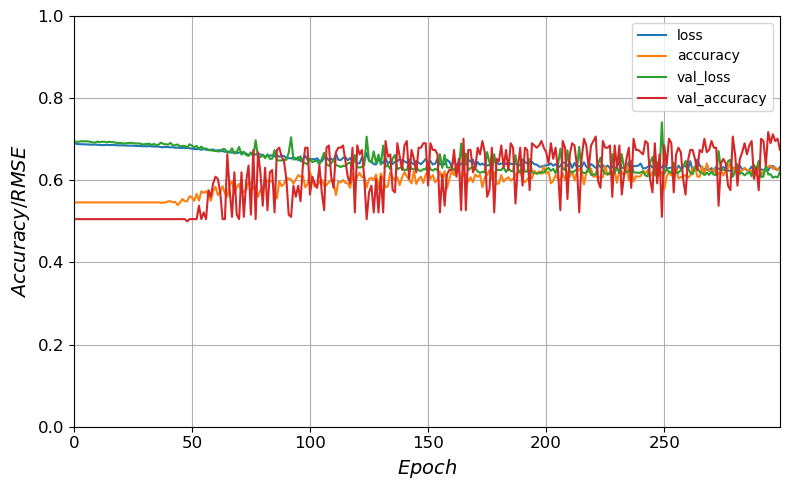

In [65]:
pd.DataFrame(model_history_LLE.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.xlabel("$Epoch$", fontsize=14)
plt.ylabel("$Accuracy/RMSE$", fontsize=14)

save_fig("LLE_keras_learning_curves_plot")
plt.show()

231/231 [==============================] - 0s 78us/sample - loss: 1.0587 - accuracy: 0.5065
[1.0587074901118423, 0.5064935]
                      precision    recall  f1-score   support

      No signs of DR       0.51      0.31      0.39       115
Contains signs of DR       0.51      0.70      0.59       116

            accuracy                           0.51       231
           macro avg       0.51      0.51      0.49       231
        weighted avg       0.51      0.51      0.49       231



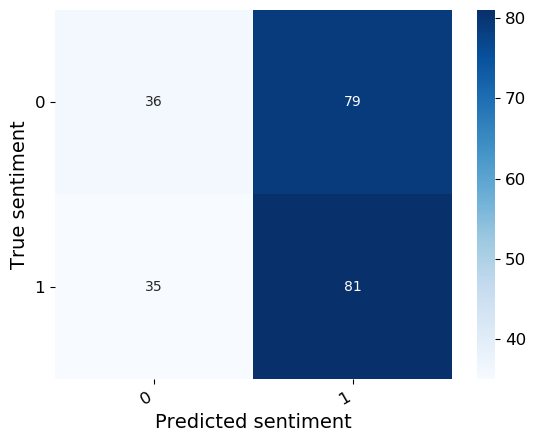

In [84]:
X_test_LLE = lle.fit_transform(messidor_test_prep)
acc = model_NN_LLE.evaluate(X_test_LLE,messidor_test_labels_prep)
print(acc)
y_pred_LLE = model_NN_LLE.predict_classes(X_test_LLE)

cm = confusion_matrix(messidor_test_labels_prep, y_pred_LLE)
df_cm = pd.DataFrame(cm)#, index=Class_label[:], columns=Class_label[:])
show_confusion_matrix(df_cm)
print(classification_report(messidor_test_labels_prep, y_pred_LLE, target_names=Class_label[:]))